In [4]:
pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 10.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import sklearn
import keras
import pickle
import tensorflow.keras as keras
import collections
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
from keras.optimizers import Adam, RMSprop, SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
#from terbilang import Terbilang

#t = Terbilang()
#nltk.download('stopwords')
#nltk.download('all')

In [6]:
#to print complete sentence
pd.options.display.max_colwidth = 500

In [7]:
#kamus
df1 = pd.read_csv('new_kamusalay.csv', encoding =  'ISO-8859-1', names=['old','new'])
df1.head()

,old,new
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [8]:
file_path = "train_preprocess.tsv.txt"
df = pd.read_csv(file_path, delimiter='\t', names=["Tweet", "Sentimen"])
#print(type(df["data"]))
#print(df["data"])

In [9]:
def cleaning_data(text):
    text = text.lower()
    text=re.sub('url', '', text)
    text = re.sub('url\S+', '', text)
    text=re.sub('http', '', text)
    text = re.sub(r'http\S+', '', text)
    #text = re.sub(r'&', 'dan', text)
    #text=re.sub(r'/', 'atau', text)
    #text = re.sub(r'&amp', 'dan', text)
    #text = re.sub(r'&lt;', '', text)
    #text = re.sub(r'&gt;', '', text)
    text = re.sub(r'%', ' persen', text)
    text = re.sub(r' {2,}', ' ', text)
    text=re.sub(r'(\\x(.){2})', '', text) #emoticon
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return text


In [10]:
# Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    #text = [stemmer.stem(word) for word in text]
    return text

#Convert list of words into sentence
#def toSentence(list_words):
#    sentence = ' '.join(word for word in list_words)
#    return sentence

In [11]:
#split the data
def convert(lst):
    return ''.join(lst).split()

In [12]:
# check with kamus alay
def filter_data(text):
        result = ""
        tweets = text
        #print(tweets)
        temp=[]
        for tweet in tweets:
            try:
                trying = np.where(kamusalay['old']==tweet)[0][0]
                tweet = kamusalay['new'].iloc[trying]
            except:
                tweet = tweet
            #print(tweet)
            temp.append(tweet)
            result = result + " " + tweet
        return result

In [13]:
df['ReviewTweet'] = df['Tweet'].apply(cleaning_data)
df['ReviewTweet']=df['ReviewTweet'].apply(convert)
df['ReviewTweet']=df['ReviewTweet'].apply(filter_data)
df['ReviewTweet'] = df['ReviewTweet'].apply(stemmingText)

**Descriptive Data Analysis**

In [14]:
class TextCounts(BaseEstimator, TransformerMixin):

    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))

    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self

    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet

        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                          })

        return df

In [15]:
tc = TextCounts()
df_eda = tc.fit_transform(df.ReviewTweet)
# Add airline_sentiment to df_eda
df_eda['sentiment'] = df.Sentimen

In [16]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.histplot, col, kde=False, bins=bins)
    plt.show()
    #if not KAGGLE_ENV: g.savefig('../output/' + col + '_dist.png')

Descriptive stats for count_words
---------------------------------
            count       mean        std  min   25%   50%   75%   max
sentiment                                                           
negative   3436.0  21.247672  16.051194  1.0  10.0  17.0  27.0  79.0
neutral    1148.0  13.396341   8.163150  2.0   8.0  11.0  16.0  65.0
positive   6416.0  36.456359  17.866700  1.0  23.0  34.0  52.0  96.0


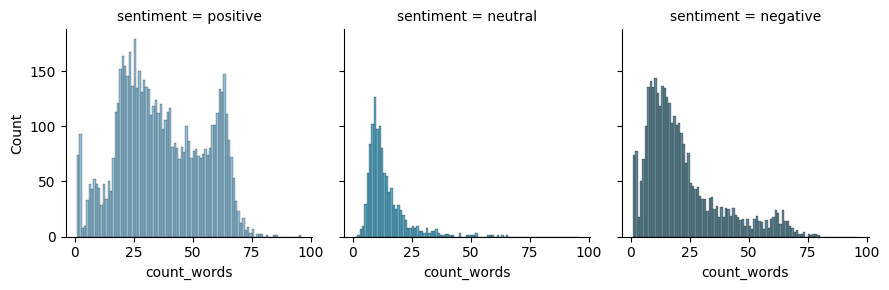

In [17]:
show_dist(df_eda, 'count_words')

**The most frequent words**

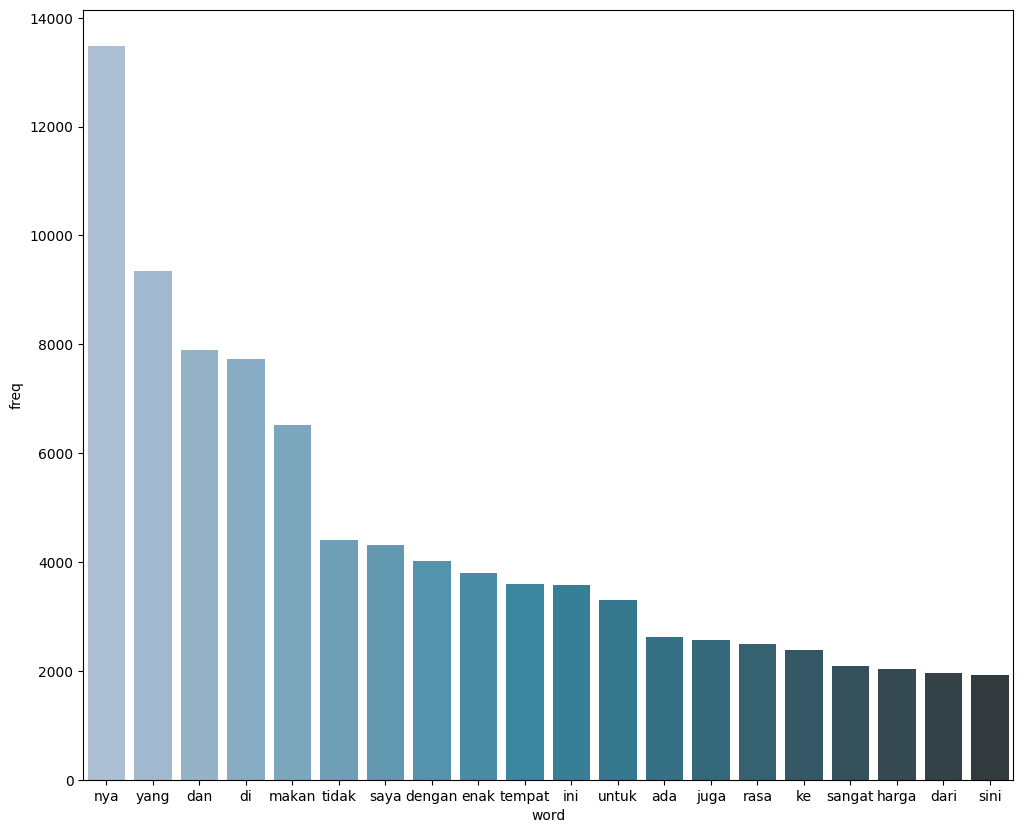

In [ ]:
data_preprocessed = df['ReviewTweet'].tolist()

vectorizer = CountVectorizer()
vectorizer.fit(data_preprocessed)
X = vectorizer.transform(data_preprocessed)
word_freq = dict(zip(vectorizer.get_feature_names_out(), np.asarray(X.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();
